# импортируем либы

In [221]:
import pandas as pd
import re
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt

# загржаем данные

In [222]:
df = pd.read_csv("..//static//csv//car_price_prediction.csv", sep=",")
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

# небольшая обработка данных

In [223]:
df['Mileage'] = df['Mileage'].str.replace(' km', '').str.replace(',', '')
df['Mileage'] = df['Mileage'].astype(int)
df['Engine volume'] = df['Engine volume'].apply(lambda x: float(re.match(r'\d+(\.\d+)?', x).group()) if isinstance(x, str) else x)
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type  Engine volume  Mileage  Cylinders Gear box type  \
0              Yes    Hybrid            3.5   186005        6.0     Automatic   
1               No    Petrol            3.0   192000        6.0     Tiptronic   
2               No    Petrol            1.3   200000        4.0      Variator   
3              Yes    Hybrid            2.5   168966        4.0     Automatic   
4              Yes    Petrol            1.3    91901        4.0     Automatic   

  Drive wheels   Doors             Wheel   Color  Airbags  
0          4x4  04-May        Left wheel  Silver       12  
1          4x4  04-May        Left wheel   Black        8  
2        Front  04-May  Right-hand drive   Black        2  
3          4x4  04-May        Left wheel   White        0  
4        Front  04-May        Left wheel  Silver        4

# Выбор входных и выходных переменных
Перед тем как строить нечеткую систему, нужно определить, какие переменные будут входными, а какие – выходными. 
   
### Входные переменные (fuzzy inputs):
- Prod. year (год выпуска) – влияет на цену машины.
- Mileage (пробег) – чем выше пробег, тем дешевле машина.
  
### Выходная переменная (fuzzy output):
- Price (цена) – оцениваемая стоимость автомобиля.

# Настройка лингвистических переменных  
Определяем, какие термы будут у каждой переменной, их тип (например, треугольные или гауссовые функции принадлежности) и параметры. 
   
### Продолжительность эксплуатации (Prod. year)
- Старый (Old)
- Средний (Medium)
- Новый (New)
  
### Пробег (Mileage)
- Маленький (Low)
- Средний (Medium)
- Большой (High)
  
### Цена (Price)
- Дешевая (Cheap)
- Средняя (Medium)
- Дорогая (Expensive)

In [224]:
pryMin, pryMax = df['Prod. year'].quantile(0.01), df['Prod. year'].quantile(0.97)
milMin, milMax = df['Mileage'].quantile(0.01), df['Mileage'].quantile(0.80)
priMin, priMax = df['Price'].quantile(0.01), df['Price'].quantile(0.97)

# Определяем диапазоны переменных
prod_year = np.arange(pryMin, pryMax, 1)  # Годы выпуска
mileage = np.arange(milMin, milMax, 1)  # Пробег
price = np.arange(priMin, priMax, 1) # Цена

# Определение переменных
prod_year_ctrl = ctrl.Antecedent(prod_year, 'prod_year')
mileage_ctrl = ctrl.Antecedent(mileage, 'mileage')
price_ctrl = ctrl.Consequent(price, 'price')

# Настраиваем функции принадлежности

d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


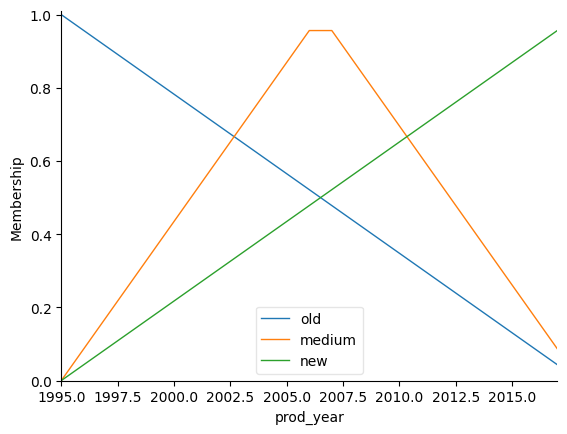

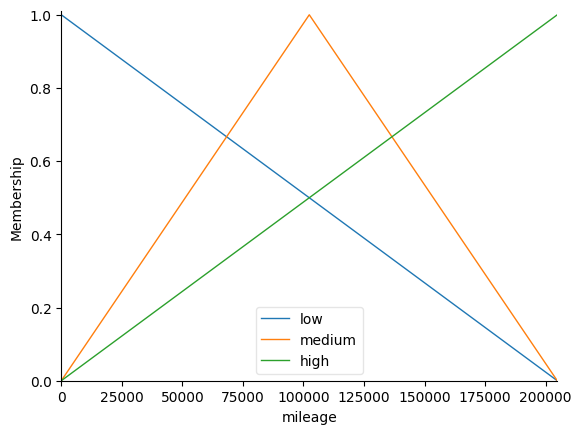

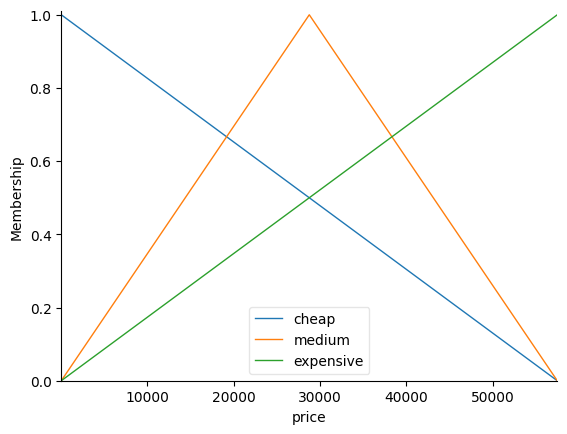

In [225]:
# Функции принадлежности
pryMid = (pryMin+pryMax)/2
prod_year_ctrl['old'] = fuzz.trimf(prod_year, [pryMin, pryMin, pryMax])
prod_year_ctrl['medium'] = fuzz.trimf(prod_year, [pryMin, pryMid, pryMax])
prod_year_ctrl['new'] = fuzz.trimf(prod_year, [pryMin, pryMax, pryMax])

milMid = (milMin+milMax)/2
mileage_ctrl['low'] = fuzz.trimf(mileage, [milMin, milMin, milMax])
mileage_ctrl['medium']  = fuzz.trimf(mileage, [milMin, milMid, milMax])
mileage_ctrl['high'] = fuzz.trimf(mileage, [milMin, milMax, milMax])

priMid = (priMin+priMax)/2
price_ctrl['cheap'] = fuzz.trimf(price, [priMin, priMin, priMax])
price_ctrl['medium'] = fuzz.trimf(price, [priMin, priMid, priMax])
price_ctrl['expensive'] = fuzz.trimf(price, [priMin, priMax, priMax])

# визуализируем
prod_year_ctrl.view()
mileage_ctrl.view()
price_ctrl.view()

# Формирование базы нечетких правил
Создаем логические зависимости между входными и выходными переменными. 
  
### правила: 
1. Если машина старая и пробег высокий, то цена дешевая.
2. Если машина средняя по возрасту и пробег средний, то цена средняя.
3. Если машина новая и пробег маленький, то цена дорогая.

In [226]:
# Определение правил
rule1 = ctrl.Rule(prod_year_ctrl['old'] & mileage_ctrl['high'], price_ctrl['cheap'])
rule2 = ctrl.Rule(prod_year_ctrl['medium'] & mileage_ctrl['medium'], price_ctrl['medium'])
rule3 = ctrl.Rule(prod_year_ctrl['new'] & mileage_ctrl['low'], price_ctrl['expensive'])

# Создаем систему
price_control = ctrl.ControlSystem([rule1, rule2, rule3])
price_simulation = ctrl.ControlSystemSimulation(price_control)

d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\skfuzzy\control\controlsystem.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


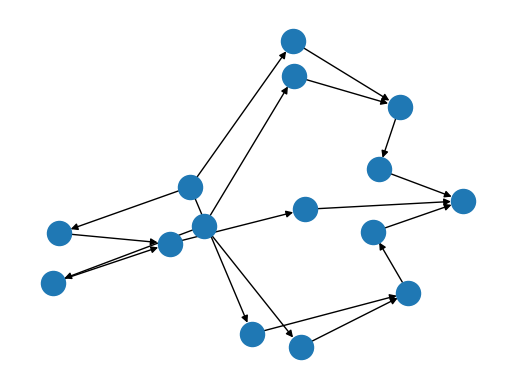

In [227]:
price_control.view()

# Оценка качества нечеткой системы
Чтобы проверить работу модели, можно подать тестовые данные и посмотреть, как система определяет цену.  


 Antecedents 
Antecedent: prod_year               = 2014
  - old                             : 0.17391304347826086
  - medium                          : 0.34782608695652173
  - new                             : 0.8260869565217391
Antecedent: mileage                 = 65000
  - low                             : 0.6826171875
  - medium                          : 0.634765625
  - high                            : 0.3173828125

 Rules 
RULE #0:
  IF prod_year[old] AND mileage[high] THEN price[cheap]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - prod_year[old]                                         : 0.17391304347826086
  - mileage[high]                                          : 0.3173828125
                          prod_year[old] AND mileage[high] = 0.17391304347826086
  Activation (THEN-clause):
                                              price[cheap] : 0.17391304347826086

RULE #1:
  IF prod_year[medium] AND mileage[medium] THEN pri

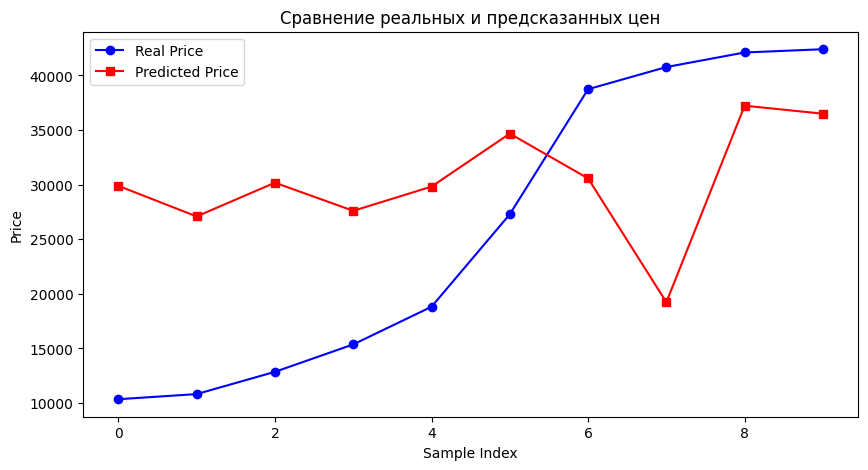

In [228]:
# Выбираем случайные 10 записей для тестирования
sample_df = df[['Prod. year', 'Mileage', 'Price']].sample(10, random_state=42)
sample_df = sample_df.reset_index(drop=True)

predicted_prices = []

for i in range(len(sample_df)):
    price_simulation.input['prod_year'] = sample_df.loc[i, 'Prod. year']
    price_simulation.input['mileage'] = sample_df.loc[i, 'Mileage']
    price_simulation.compute()
    a = price_simulation.print_state()
    predicted_prices.append(price_simulation.output['price'])

sample_df['Predicted Price'] = predicted_prices
sample_df_sorted = sample_df.sort_values(by='Price')


# Вывод результатов
print(sample_df_sorted[['Prod. year', 'Mileage', 'Price', 'Predicted Price']])

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(sample_df.index, sample_df_sorted['Price'], marker='o', label='Real Price', color='blue')
plt.plot(sample_df.index, sample_df_sorted['Predicted Price'], marker='s', label='Predicted Price', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.title("Сравнение реальных и предсказанных цен")
plt.show()

Система ужасно предсказывает цену, не может предсказать ни большую цену ни маленькую, потому что она хорошо предсказывает категорию, но цену по категории не может